In [4]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
# openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_key = 'your api key'
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:

def plot_preds(train, test, pred_dict, model_name, mse, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.title(model_name)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    mse_name = model_name + '_mse'
    # plt.text(0.03, 0.85, f'{mse_name}: {mse:.2f} ')
    plt.text(0.03, 0.85, f'{mse_name}: {mse:.2f} ', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    # if 'NLL/D' in pred_dict:
    #     nll = pred_dict['NLL/D']
    #     if nll is not None:
    #         plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [5]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    # 'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    # 'PromptCast GPT-3.5':{'model': 'gpt-3.5-turbo-instruct', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    # 'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [7]:
from sklearn.metrics import mean_squared_error
def out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names):
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        
        pred = pred_dict['median']
        pred = pd.Series(pred, index=test.index)
        mse = mean_squared_error(test, pred)
        out[model+"_mse"] = mse
        plot_preds(train, test, pred_dict, model, mse, show_samples=False)
    return out

# AirPassengersDataset

test length: 29
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


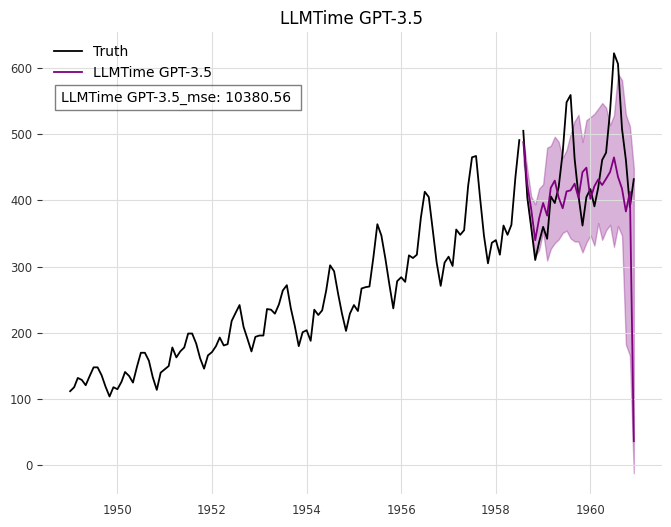

Train length: 86, Val length: 29


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparamet

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL 3.765951


d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


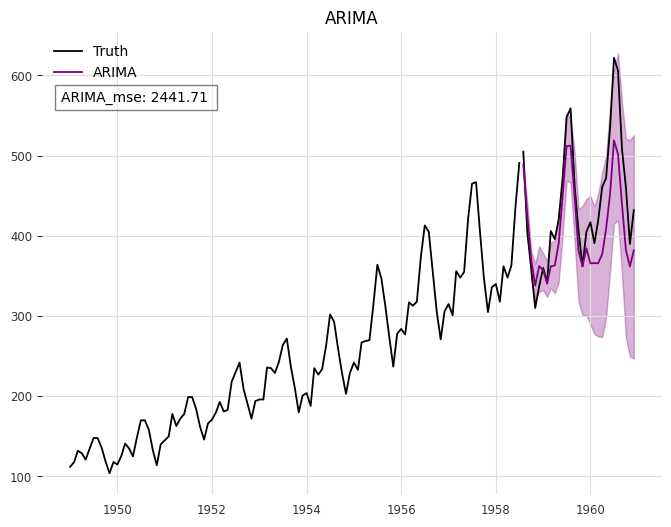

AirPassengersDataset_LLMTime GPT-3.5_mse: 10380.55596664655
AirPassengersDataset_ARIMA_mse: 2441.7108861527804


In [14]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'
# ds_name = 'GasRateCO2Dataset'
# ds_name = 'SunspotsDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
print('test length:', len(test))
res = out(train, test, ds_name)
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# GasRateCO2Dataset

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:06<00:00,  6.93s/it]


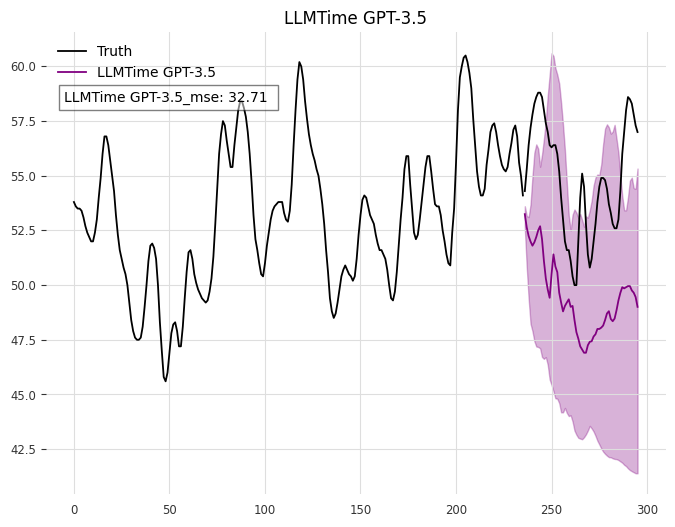

Train length: 176, Val length: 60


Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.58it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  75%|███████▌  | 3/4 [00:12<00:05,  5.57s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 1, 'q': 0, 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL 1.002368


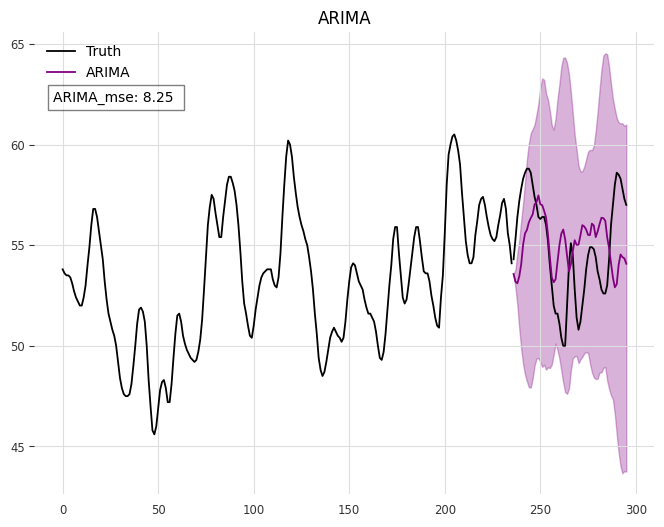

GasRateCO2Dataset_LLMTime GPT-3.5_mse: 32.713463228729566
GasRateCO2Dataset_ARIMA_mse: 8.253491306573446


In [15]:
datasets = get_datasets()
# ds_name = 'AirPassengersDataset'
ds_name = 'GasRateCO2Dataset'
# ds_name = 'SunspotsDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
print(len(test))
res = out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names)
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])
# res = out(train, test, ds_name)
# print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
# print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# SunspotsDataset

100
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'SunspotsDataset'}) 
 with NLL inf




















100%|██████████| 1/1 [00:14<00:00, 14.01s/it]


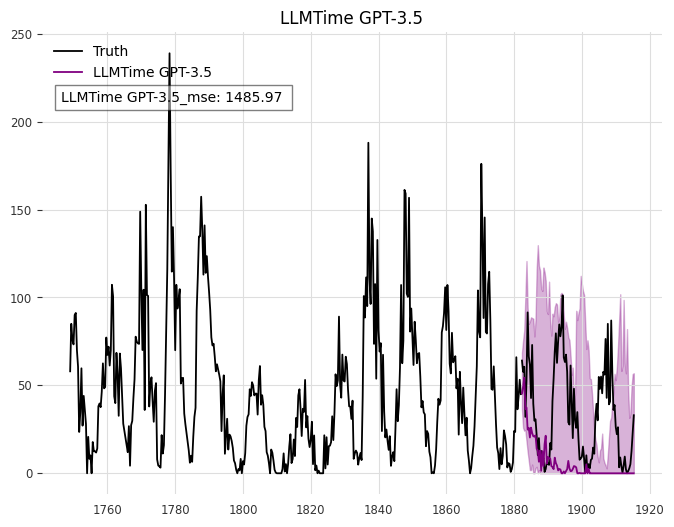

Train length: 300, Val length: 100















































Hyperparameter search: 100%|██████████| 4/4 [00:21<00:00,  5.33s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0, 'dataset_name': 'SunspotsDataset'}) 
 with NLL 4.465730


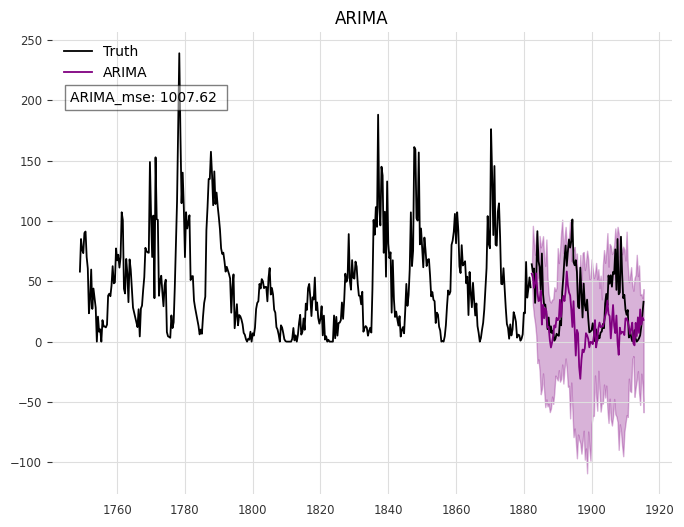

SunspotsDataset_LLMTime GPT-3.5_mse: 1485.974583142143
SunspotsDataset_ARIMA_mse: 1007.6228688762857


In [35]:
import darts.datasets
ds_name = 'SunspotsDataset'
testfrac = 0.2
darts_ds = getattr(darts.datasets,ds_name)().load()
series = darts_ds.pd_series()
series = series.iloc[::4]
series = series[:500]  # very big 
splitpoint = int(len(series)*(1-testfrac))
train = series.iloc[:splitpoint]
test = series.iloc[splitpoint:]
print(len(test))
res = out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names)
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# MonthlyMilkDataset

34
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf




















100%|██████████| 1/1 [00:04<00:00,  4.44s/it]


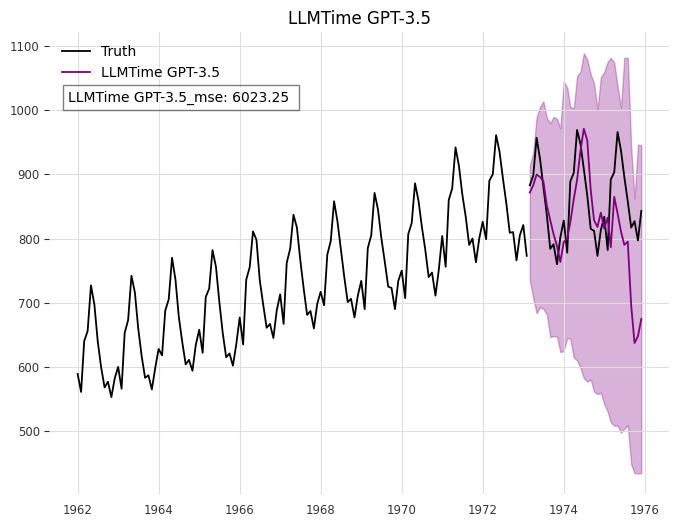

Train length: 100, Val length: 34











d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "









d:\software\python\lib\site-packages\statsmodels\tsa\s

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0, 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL 3.680180


d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


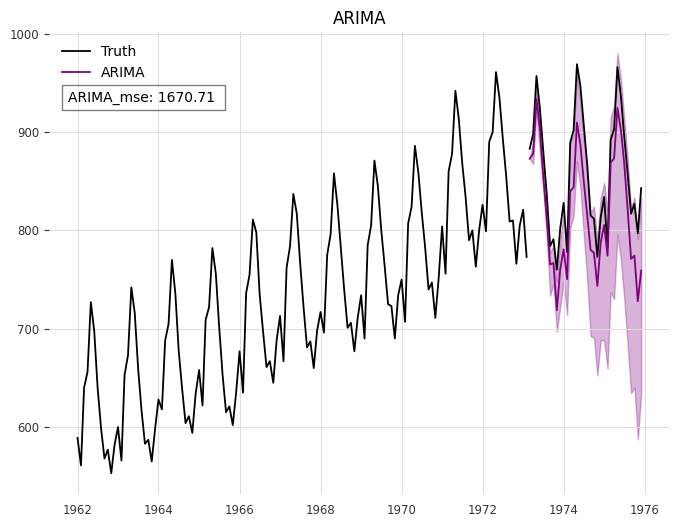

MonthlyMilkDataset_LLMTime GPT-3.5_mse: 6023.246325830591
MonthlyMilkDataset_ARIMA_mse: 1670.7120381490151


In [38]:
datasets = get_datasets()
ds_name = 'MonthlyMilkDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
print(len(test))
res = out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names)
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# WineDataset

36
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




















100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


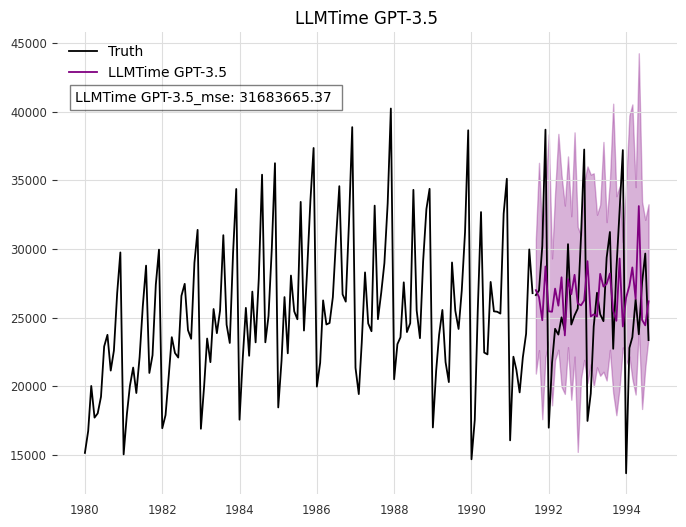

Train length: 104, Val length: 36











d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "









d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "









d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 1, 'q': 0, 'dataset_name': 'WineDataset'}) 
 with NLL 9.781750


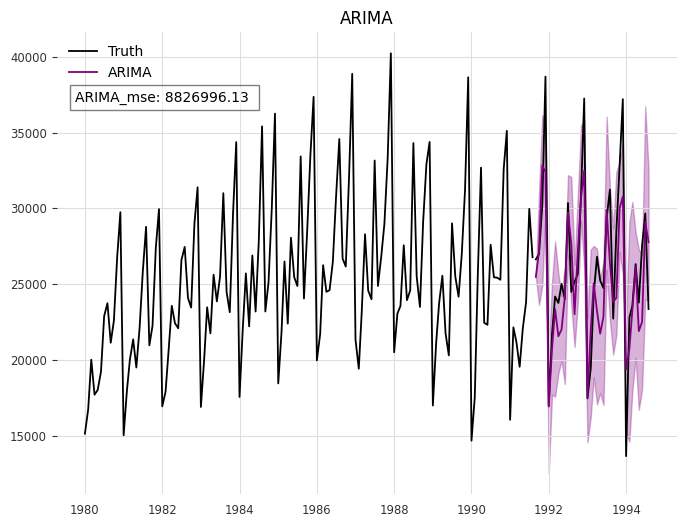

WineDataset_LLMTime GPT-3.5_mse: 31683665.370521706
WineDataset_ARIMA_mse: 8826996.125348382


In [39]:
datasets = get_datasets()
ds_name = 'WineDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
print(len(test))
res = out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names)
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# HeartRateDataset

100
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'HeartRateDataset'}) 
 with NLL inf






















100%|██████████| 1/1 [00:13<00:00, 13.89s/it]


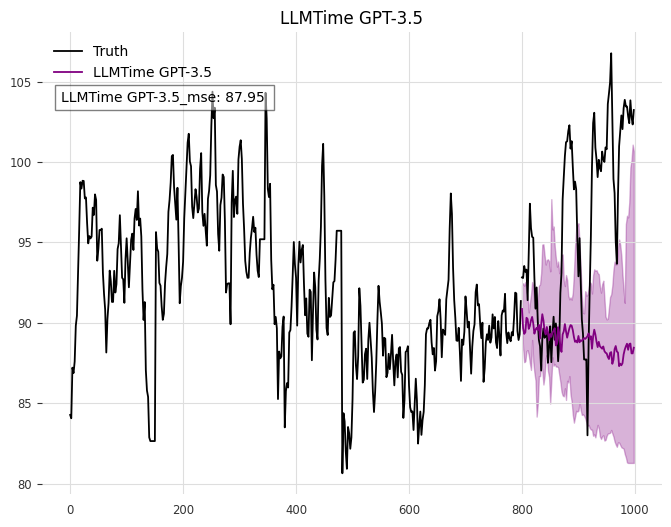

Train length: 300, Val length: 100




















































Hyperparameter search: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 30, 'd': 1, 'q': 0, 'dataset_name': 'HeartRateDataset'}) 
 with NLL 1.884214


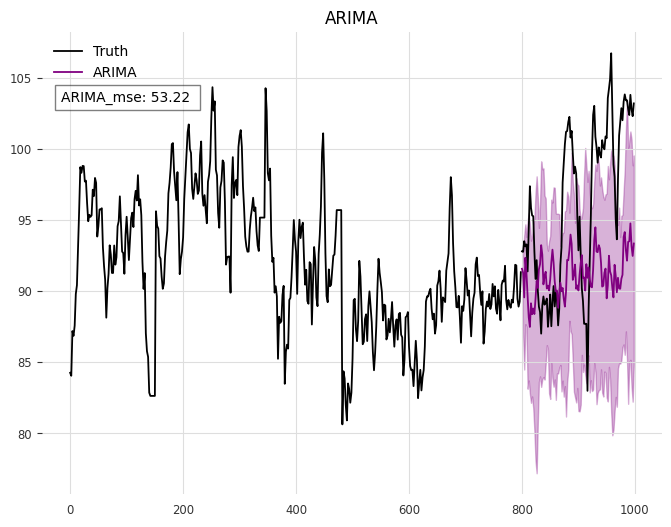

HeartRateDataset_LLMTime GPT-3.5_mse: 87.94668278461347
HeartRateDataset_ARIMA_mse: 53.217866467566964


In [44]:
import darts.datasets
ds_name = 'HeartRateDataset'
testfrac = 0.2
darts_ds = getattr(darts.datasets,ds_name)().load()
series = darts_ds.pd_series()
series = series.iloc[::2]
series = series[:500]  # very big 
splitpoint = int(len(series)*(1-testfrac))
train = series.iloc[:splitpoint]
test = series.iloc[splitpoint:]
print(len(test))
res = out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names)
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])